# Contrastive Learning for Predicting Cancer Prognosis Using Gene Expression Values

## Sample Model Training

TrainCL4CaPro.ipynb notebook is offering detailed step-by-step instructions on how to train a CL4CaPro model from the ground up and validate its performance.

### Prepare Dataset

Put TCGA-CDR-SupplementalTableS1.xlsx and EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv in the same path with *ExtractData.py*. You can download them in OneDrive folder TCGA (https://miamiedu-my.sharepoint.com/:f:/r/personal/x_cai_miami_edu/Documents/CaixdLab/CL4CaPro/CL4CaPro_Models/TCGA?csf=1&web=1&e=IZYpyp)

#### ExtractData from TCGA Table

In [ ]:
! python ExtractData.py

Then put EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv in the same path and run following script by modifying cancer name you want

#### Define Functions

In [ ]:
import pandas as pd
import numpy as np

def loadGen():
    Gendata = pd.read_csv('EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv',sep='\t')
    gene_id_list = Gendata['gene_id'].tolist()
    return Gendata, gene_id_list

def loadCancer(CancerType):
    CancerDataPath = './' + CancerType + 'Data.csv'
    data = pd.read_csv(CancerDataPath)
    return data

def AggregateInfo(data):
    Agg_Info = []
    for index, row in data.iterrows():
        bcr = row['bcr_patient_barcode'].split('-')
        PFI = row['PFI.1'] #row['DSS_cr']
        PFItime = row['PFI.time.1'] #row['DSS.time.cr']
        try:
            if int(PFI) != 0:
                PFI = 1
        except:
            PFI = 1
        Agg_Info.append([bcr, PFI, PFItime])
    return Agg_Info

def PreproData(Agg_Info, Gendata, CancerType):
    PreprocessedData = []
    for bcr, PFI, PFItime in Agg_Info:
        Agg_Gen_Info = ['-'.join(bcr), PFI, PFItime, CancerType]
        MatchFlag = 0
        for col in Gendata.columns.values:
            col_info = col.split('-')
            #Match Bar Code
            if col_info[0:3] == bcr[0:3]:
                number = int(col_info[3][0:2])
                if MatchFlag == 1:
                    #print('WARN: multiple match: ', col_info)
                    if number > 0 and number < 10: #multi-tumor samples
                        print('Multi-tumor samples: ', col)
                else:
                    #Check tumor sample
                    if number > 0 and number < 10: #tumor
                        Agg_Gen_Info.append(col)
                        MatchFlag = 1
                        GenGet = Gendata[col].tolist() #Get all gen data in the column
                        #Check missing values or negative values
                        for item in GenGet:
                            if item == 'NaN' or float(item) < 0:
                                Agg_Gen_Info.append(np.nan)
                                print('Find None or Negative')
                            else:
                                Agg_Gen_Info.append(item)#math.log2(item + 1))
                    else:
                        print('Find normal sample: ', col)
        if MatchFlag == 0:
            print('UnMatched:', Agg_Gen_Info)
        else:
            PreprocessedData.append(Agg_Gen_Info)
    return PreprocessedData

def add_header(gene_id_list):
    agg_header = gene_id_list
    agg_header.insert(0, 'bar')
    agg_header.insert(1, 'PFI')
    agg_header.insert(2, 'PFItime')
    agg_header.insert(3, 'gen_id')
    agg_header.insert(4, 'type')
    return agg_header

def saveDF(PreprocessedData, CancerType, agg_header):
    PreprocessedDF = pd.DataFrame(PreprocessedData, columns = agg_header)
    PreprocessedDF.to_csv('./' + CancerType + 'RawGeneData.txt', index=None)

#### Build Data for given cancer
Sample cancer is BRCA
The available single cancer for TCGA dataset including:
"BLCA", "BRCA", "CESC", "COAD", "GBM", "HNSC", "KIRC", "KIRP", "LGG", "LIHC", "LUAD", "LUSC", "OV", "PRAD", "SARC", "SKCM", "STAD", "THCA", "UCEC"
The available cancer groups for TCGA dataset including:
"SM": ['BLCA', 'CESC', 'ESCA', 'HNSC', 'LUSC']
"NGT": ['GBM', 'LGG', 'PCPG']
"MSE": ['SKCM', 'UVM']
"CCPRC": ['KIRC', 'KIRP']
"HC": ['CHOL', 'LIHC']
"GG": ['COAD', 'READ', 'ESCA', 'STAD']
"DS": ['PAAD', 'STAD']
"LC": ['LUAD', 'LUSC']

In [ ]:
Cancer_Name = 'BRCA' # Change cancer name or cancer group name

In [ ]:
if Cancer_Name == 'SM':
    CancerTypeList = ['BLCA', 'CESC', 'ESCA', 'HNSC', 'LUSC']
elif Cancer_Name == 'NGT':
    CancerTypeList = ['GBM', 'LGG', 'PCPG']
elif Cancer_Name == 'MSE':
    CancerTypeList = ['SKCM', 'UVM']
elif Cancer_Name == 'CCPRC':
    CancerTypeList = ['KIRC', 'KIRP']
elif Cancer_Name == 'HC':
    CancerTypeList = ['CHOL', 'LIHC']
elif Cancer_Name == 'GG':
    CancerTypeList = ['COAD', 'READ', 'ESCA', 'STAD']
elif Cancer_Name == 'DS':
    CancerTypeList = ['PAAD', 'STAD']
elif Cancer_Name == 'LC':
    CancerTypeList = ['LUAD', 'LUSC']
else:
    CancerTypeList = [Cancer_Name]

In [ ]:
CancerGroupName = Cancer_Name
TotalData = []
Gendata, gene_id_list = loadGen()
agg_header = add_header(gene_id_list)
for eachCancer in CancerTypeList:
    print('Processing: ', eachCancer)
    data = loadCancer(eachCancer)
    Agg_Info = AggregateInfo(data)
    PreprocessedData = PreproData(Agg_Info, Gendata, eachCancer)
    TotalData = TotalData + PreprocessedData
    saveDF(PreprocessedData, eachCancer, agg_header)
    print('Preprocess Successfully')
saveDF(TotalData, 'Total_' + CancerGroupName + '_', agg_header)
print('Total Data Saved.')

#### Build WholeTimeSeq Dataset for Cox

In [ ]:
cancer_group = Cancer_Name
data_get = pd.read_csv('TotalData_' + cancer_group + '.txt')
data_get.insert(4, 'predicted_label', 0, True)
timelist = data_get['PFItime'].tolist()
timelist.sort()
for n in [6, 8, 10, 12]:
    div_point = []
    timelabel = []
    for i in range(n):
        div_point.append(timelist[int(len(timelist) / n * i)])
    print(div_point)
    for item in data_get['PFItime'].tolist():
        i = 0
        while item >= div_point[i] and i < (n - 1):
            i += 1
        if item >= div_point[i] and i == (n - 1):
            i += 1
        timelabel.append(i - 1)
    data_get['predicted_label'] = np.array(timelabel)
    data_get.to_csv('DataSet/CancerRNA_' + cancer_group + '_WholeTimeSeq_' + str(n) + '.txt', index=None)

#### Build WholeTimeSeq Dataset for Classifier

In [ ]:
cancer_get = Cancer_Name
threshold = 0
n = 2
div_point = [1] * n
threshold = 3 * 365
data_get = pd.read_csv('TotalRawData_' + cancer_group + '.txt')
data_get = data_get[data_get.gen_id == cancer_get]
data_get = data_get[(data_get.PFI == 1) | (data_get.PFItime > threshold)]
data_get.insert(4, 'predicted_label', 0, True)

timelabel = []
for item in data_get['PFItime'].tolist():
    i = 0
    if item < threshold:
        timelabel.append(0)
    else:
        timelabel.append(1)

data_get['predicted_label'] = np.array(timelabel)
data_get.to_csv('DataSet/CancerRNA_' + cancer_get + '_Risk_' + str(n) + '.txt', index=None)

### Model Training
All 40 seed models will be trained through the follwing code, GPU required. Default threads setting to 4 for RTX 4090 24Gb.
#### Train Contrastive Learning Model for Classifier

In [ ]:
! python Auto_Train_GPU.py --cancer_group {Cancer_Name} --task Classifier

#### Train Contrastive Learning Model for Cox

In [ ]:
! python Auto_Train_GPU.py --cancer_group {Cancer_Name} --task Cox

### Test and Validate CL4CaPro Model
#### All 40 seeds Classifier Results

In [ ]:
! python Auto_Vali.py --cancer_group {Cancer_Name} --task Classifier

#### All 40 seeds Cox Results

In [ ]:
! python Auto_Vali.py --cancer_group {Cancer_Name} --task Cox

#### Single Seed Classifier Results
Pick one seed from the following seed list we provided in the Auto_Train_GPU.py then run the following command, you will see the results of the picked seed.
seed_list = [10, 74, 341, 925, 1036, 1555, 1777, 2030, 2060, 2090, 2200,
             2222, 2268, 2289, 2341, 2741, 2765, 2782, 2857, 2864, 2918,
             2937, 2948, 2960, 2968, 3005, 3008, 3154, 3199, 3212, 3388,
             3455, 3466, 3611, 3679, 3927, 4000, 4013, 4416, 4520]

In [ ]:
! python Auto_Vali.py --cancer_group {Cancer_Name} --task Classifier --seed {seed} --core 20 > ClassifierLog/{}.log &

#### Single Seed Cox Resutls

In [ ]:
! python Auto_Vali.py --cancer_group {Cancer_Name} --task Cox --seed {seed} --core 20 > CoxLog/{}.log &

#### All 40 seeds Classifier Results Samples
##### Import Library

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import ranksums
plt.rcdefaults()

##### Generate Plot

UCEC


C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered

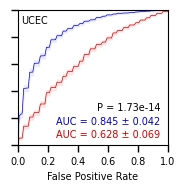

STAD


C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered

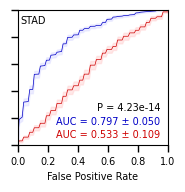

C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


SARC


C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\anchen.sun\AppData\Local\Temp\ipykernel_23372\4184451652.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']*len(xticks))


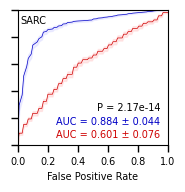

C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\anchen.sun\Anaconda3\envs\Contrastive Learning Method for Predicting Cancer Prognosis from Gene\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered

SKCM


C:\Users\anchen.sun\AppData\Local\Temp\ipykernel_23372\4184451652.py:140: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']*len(xticks))


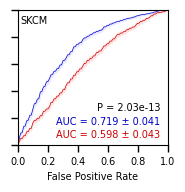

In [3]:
#cancer_group_list, x_label_flag, y_label_flag, legend_flag, (size_h, size_w, mode_type) = ["BRCA", "KIRC", "LUAD", "LUSC", "OV", "CESC", "COAD", "KIRP", "LGG"], False, False, False, (2, 1.8*0.84, 'C')
#cancer_group_list, x_label_flag, y_label_flag, legend_flag, (size_h, size_w, mode_type) = ["HNSC", "LIHC"], False, True, False, (2, 1.8*0.84, 'L')
#cancer_group_list, x_label_flag, y_label_flag, legend_flag, (size_h, size_w, mode_type) = ["BLCA"], False, True, True, (2, 1.8*0.84, 'L')
#cancer_group_list, x_label_flag, y_label_flag, legend_flag, (size_h, size_w, mode_type) = ["PRAD", "THCA"], True, True, False, (2, 1.8, 'LB')
cancer_group_list, x_label_flag, y_label_flag, legend_flag, (size_h, size_w, mode_type) = ["UCEC", "STAD", "SARC", "SKCM"], True, False, False, (2, 1.8, 'B')

for cancer_get in cancer_group_list:

    print(cancer_get)

    # Given file path
    extracted_folder_path = 'PaperFigures/ROCData'

    # Listing the contents of the extracted folder
    extracted_files = os.listdir(extracted_folder_path)

    # Function to load FPR and TPR values from a given file
    def load_fpr_tpr(file_path):
        data = pd.read_csv(file_path)
        return data["FPR"], data["TPR"]

    # Loading FPR and TPR values from all the files
    fpr_list, tpr_list = [], []
    for file_name in extracted_files:
        if cancer_get in file_name:
            file_path = os.path.join(extracted_folder_path, file_name)
            fpr, tpr = load_fpr_tpr(file_path)
            fpr_list.append(fpr)
            tpr_list.append(tpr)

    # Defining a common set of FPR levels for interpolation
    common_fpr_levels = np.linspace(0, 1, 100)

    # Interpolating TPR values at the common FPR levels
    interpolated_tpr_values = []
    for fpr, tpr in zip(fpr_list, tpr_list):
        # Creating an interpolation function
        interp_func = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value="extrapolate")

        # Interpolating the TPR values
        interpolated_tpr = interp_func(common_fpr_levels)
        interpolated_tpr_values.append(interpolated_tpr)

    # Converting the list of arrays to a 2D NumPy array and filling NaN values
    interpolated_tpr_array = np.vstack(interpolated_tpr_values)
    min_valid_value = np.nanmin(interpolated_tpr_array)
    interpolated_tpr_array = np.nan_to_num(interpolated_tpr_array, nan=min_valid_value)

    # Calculating the mean and standard error of the TPR
    mean_tpr = np.mean(interpolated_tpr_array, axis=0)
    stderr_tpr = np.std(interpolated_tpr_array, axis=0) / np.sqrt(interpolated_tpr_array.shape[0])

    # Vectorized AUC calculation using trapezoidal rule
    auc_roc_values_interpolated_CL = np.trapz(interpolated_tpr_array, common_fpr_levels, axis=1)

    # Calculating the average and standard deviation of AUC-ROC
    average_auc_roc_interpolated_CL = auc_roc_values_interpolated_CL.mean()
    std_auc_roc_interpolated_CL = auc_roc_values_interpolated_CL.std()

    # Creating the ROC plot
    fig, ax = plt.subplots(figsize=(size_h, size_w))
    ax.plot(common_fpr_levels, mean_tpr, color='#0000C6', lw=0.5, label='CL-XGBoost')
    ax.fill_between(common_fpr_levels, mean_tpr - stderr_tpr, mean_tpr + stderr_tpr, color='#DDDDFF', alpha=0.5)#, label='CL Std. Error')#, edgecolor='none')

    # Given file path
    extracted_folder_path = 'PaperFigures/ROCData_bench'

    # Listing the contents of the extracted folder
    extracted_files = os.listdir(extracted_folder_path)

    # Function to load FPR and TPR values from a given file
    def load_fpr_tpr(file_path):
        data = pd.read_csv(file_path)
        return data["FPR"], data["TPR"]

    # Loading FPR and TPR values from all the files
    fpr_list, tpr_list = [], []
    for file_name in extracted_files:
        if cancer_get in file_name:
            file_path = os.path.join(extracted_folder_path, file_name)
            fpr, tpr = load_fpr_tpr(file_path)
            fpr_list.append(fpr)
            tpr_list.append(tpr)

    # Defining a common set of FPR levels for interpolation
    common_fpr_levels = np.linspace(0, 1, 100)

    # Interpolating TPR values at the common FPR levels
    interpolated_tpr_values = []
    for fpr, tpr in zip(fpr_list, tpr_list):
        # Creating an interpolation function
        interp_func = interp1d(fpr, tpr, kind='linear', bounds_error=False, fill_value="extrapolate")

        # Interpolating the TPR values
        interpolated_tpr = interp_func(common_fpr_levels)
        interpolated_tpr_values.append(interpolated_tpr)

    # Converting the list of arrays to a 2D NumPy array and filling NaN values
    interpolated_tpr_array = np.vstack(interpolated_tpr_values)
    min_valid_value = np.nanmin(interpolated_tpr_array)
    interpolated_tpr_array = np.nan_to_num(interpolated_tpr_array, nan=min_valid_value)

    # Calculating the mean and standard error of the TPR
    mean_tpr = np.mean(interpolated_tpr_array, axis=0)
    stderr_tpr = np.std(interpolated_tpr_array, axis=0) / np.sqrt(interpolated_tpr_array.shape[0])

    # Vectorized AUC calculation using trapezoidal rule
    auc_roc_values_interpolated_nonCL = np.trapz(interpolated_tpr_array, common_fpr_levels, axis=1)

    # Calculating the average and standard deviation of AUC-ROC
    average_auc_roc_interpolated_nonCL = auc_roc_values_interpolated_nonCL.mean()
    std_auc_roc_interpolated_nonCL = auc_roc_values_interpolated_nonCL.std()

    ax.plot(common_fpr_levels, mean_tpr, color='#CE0000', lw=0.5, label='XGBoost')
    ax.fill_between(common_fpr_levels, mean_tpr - stderr_tpr, mean_tpr + stderr_tpr, color='#FFD2D2', alpha=0.5)#, label='Std. Error')#, edgecolor='none')

    # Set the colors of the axes to black
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')

    # Remove gridlines
    ax.grid(False)

    ax.xaxis.set_tick_params(width=1, length=5, color='black')
    ax.yaxis.set_tick_params(width=1, length=5, color='black')

    #plt.xlabel('False Positive Rate (FPR)', fontsize=7)
    if y_label_flag:
        plt.ylabel('True Positive Rate', fontsize=7)
    else:
        ax = plt.gca()
        xticks = ax.get_yticks()
        ax.set_yticklabels(['']*len(xticks))

    if x_label_flag:
        plt.xlabel('False Positive Rate', fontsize=7)
    else:
        ax = plt.gca()
        xticks = ax.get_xticks()
        ax.set_xticklabels(['']*len(xticks))

    plt.tick_params(axis='x', labelsize=7)
    plt.tick_params(axis='y', labelsize=7)
    plt.text(0.02, 0.9, cancer_get, fontsize=7, ha='left')

    # Adding AUC-ROC as text annotation in the right bottom corner
    plt.text(0.95, 0.15, f'AUC = {average_auc_roc_interpolated_CL:.3f} ± {std_auc_roc_interpolated_CL:.3f}', fontsize=7, ha='right', color='#0000C6')

    # Adding AUC-ROC as text annotation in the right bottom corner
    plt.text(0.95, 0.05, f'AUC = {average_auc_roc_interpolated_nonCL:.3f} ± {std_auc_roc_interpolated_nonCL:.3f}', fontsize=7, ha='right', color='#CE0000')

    # Calculate P-value
    stat, p_value = ranksums(auc_roc_values_interpolated_CL, auc_roc_values_interpolated_nonCL)
    plt.text(0.95, 0.25, f'P = {p_value:.2e}', fontsize=7, ha='right')

    if legend_flag:
        plt.legend(loc='lower right', fontsize=7, bbox_to_anchor=(1, 0.3))

    # Setting the x-axis and y-axis limits to only show the region from 0 to 1
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    if mode_type == 'LB':
        plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.2)
    elif mode_type == 'B':
        plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.2)
    elif mode_type == 'L':
        plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.05)
    elif mode_type == 'C':
        plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.05)

    plt.show()